# Bootstrap


![Bootstrap](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/bootstrap.png)



### Lecture recap

##### Параметрический и непараметрический бутстрап
##### Оценки дисперсии функционалов

Пусть есть выборка $X = \{x_i\}_{i=1}^{n}$, некоторый функционал $T_n(X)$ и мы хотим оценить дисперсию $V_F(T_n)$. Не зная истинного распределения это можно сделать с помощью непараметрического или параметрического бутстрапа.

В непараметрическом бутстрапе оценка дисперсии делается следующим образом:

  1. Рэсемплим выборку с возвращением B раз: $X_1^*, X_2^*, X_B^* \sim X$
  2. Вычисляем $T_1^*, ..., T_B^*$
  3. $$V_F(T_n) \approx v_{boot} = \frac{1}{B - 1} \sum\limits_{b=1}^B \left(T_b^* - \bar{T}^*  \right)^2$$
  
  
Параметрический бутстрап отличается от непараметрического в первом шаге. Вместо сэмплирования из исходной выборки сэмплирование происходит из некоторого распределения, которое было найдено методом максимума правдоподобия по исходной выборке.

##### Предположим, что мы бутстрепом отобрали N событий из выборки состоящей из N наблюдений. 
  1. Какая вероятность что первый элемент бутстрепной выборки не k элемент оригинальной выборки?
  2. Какая вероятность что k элемент оригинальной выборки не входит в бутстрепную выборку?
  

##### Обоснование использование техники ресемплирования. Эффективность и состоятельность оценки плотности вероятности функцией $\hat{F}(x) = \frac{1}{N} \sum\limits_i I[x > x_i]$.

$$E\left[ \hat{F}(x) \right] = F(x)$$


$$Var \left[ \hat{F}(x) \right] = \frac{F(x)(F(x) - 1)}{n}$$

## Пример построение CDF (Cumulative distribution function) с помощью бутстрепа для треугольного распределения

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Треугольное распределение

#### Плотность распределения:

![Треугольное распределение](https://wikimedia.org/api/rest_v1/media/math/render/svg/22e4e98ad8069ea39f61fe2f0be5b83b47f631bc)

![График плотности распределения](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Triangular_distribution_PMF.png/1024px-Triangular_distribution_PMF.png)

#### Функция распределения:
![Функция распределения](https://wikimedia.org/api/rest_v1/media/math/render/svg/11b472d4e58e4df0814805aab0a2e752d6bdebf3)

![График функции распределения](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e5/Triangular_distribution_CMF.png/1024px-Triangular_distribution_CMF.png)

In [2]:
# CDF треугольного распределения с a = 0, b = 1, c = 2
def TrueTriangularDistrubition(x):
    if x < 0:
        return 0
    elif x < 1:
        return x**2 / 2
    elif x < 2:
        return 2*x - x**2 / 2 - 1
    else:
        return 1

In [3]:
# размер изначальной выборки
N = 300
# размер бутстрепной выборки
B = 800

X = np.random.uniform(0, 1, size=N) + np.random.uniform(0, 1, size=N)
Xb = np.random.choice(X, (B, N), replace=True)
Xb.shape

(800, 300)

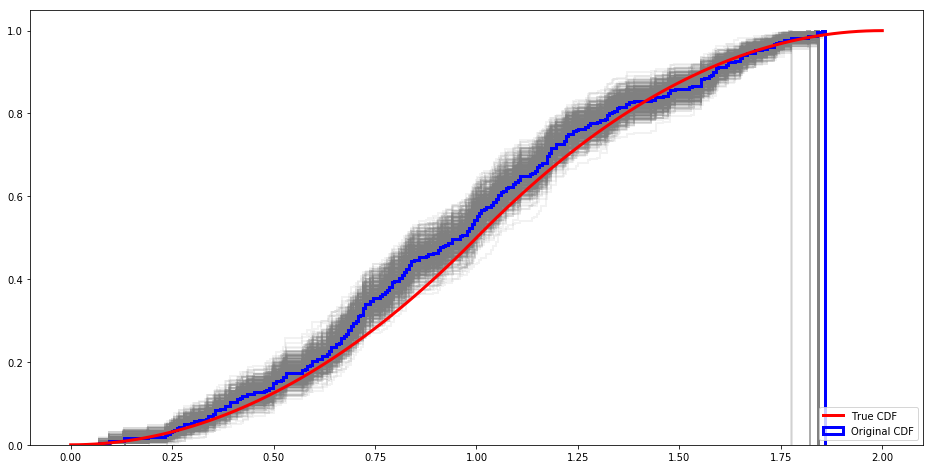

In [4]:
plt.figure(figsize = (16, 8))

# CDF для каждого бутстрепной выборки
for bootstrap_sample in Xb:
    plt.hist(bootstrap_sample, bins=N, density=True, histtype='step',
             cumulative=True, alpha = 0.1, color='grey', linewidth = 2)

# Истинное CDF
plt.plot(np.linspace(0, 2, 100), 
         list(map(TrueTriangularDistrubition, np.linspace(0, 2, 100))), 
         color = 'red', linewidth = 3, label='True CDF')    

# Эмпирическое CDF по изначальной выборке
plt.hist(X, bins=N, density=True, histtype='step',
         cumulative=True, label='Original CDF', color='blue', linewidth = 3)

plt.legend()
plt.show()

### Зависимость точности приближения распределений статистик бутстрепом

Один интересный практический вопрос это как быстро сходится бутстреп. Достаточно ли 10000 испытаний, а 1000, а 100?

В целом, чем больше тем лучше, но сейчас мы увидим, что даже для оценки CDF распределения верно что $B_k$ сходится к $B_{\infty}$(значение статистики при бесконечном количестве ресемплов) как $\frac{1}{\sqrt{n}}$.

100%|██████████| 999/999 [00:46<00:00, 21.35it/s] 


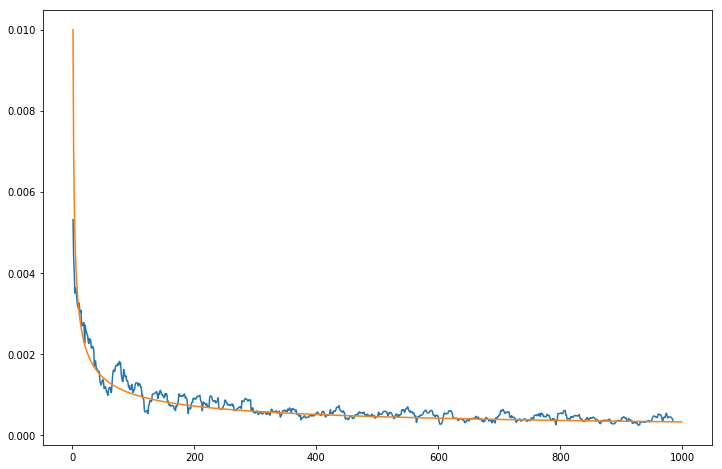

In [5]:
from tqdm import tqdm
# разбиение на бины
bins = np.linspace(0, 2, N)

# ground truth CDF
true_distr = np.array(list(map(TrueTriangularDistrubition, np.linspace(0, 2, N - 1))))

means = []

# диапазон количества испытаний для которых будем смотреть на зависимость
Bs = np.arange(1, 1000, 1)
for B in tqdm(Bs):
    # бутстрап выборки X B раз
    Xb = np.random.choice(X, (B, N), replace=True)
    cdfs = []
    for bootstrap_sample in Xb:
        # считаем разность CDF полученного бутстрапом и ground truth
        cdfs.append(
            true_distr - np.cumsum(np.histogram(bootstrap_sample, bins=bins)[0] / N)
        )
    # считаем среднее от разностей CDF
    means.append(np.array(cdfs).mean(axis=0))
    
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# считаем бегущую дисперсию, чтобы получить более гладкий график
r = np.std(rolling_window(np.array(means).mean(axis=1), 15), -1)

plt.figure(figsize=(12, 8))
plt.plot(Bs[:len(r)], r)
plt.plot(Bs, 1e-2 / np.sqrt(Bs))

На практике для оценки параметров рекомендуется использовать размер бутстрепной выборки порядка 100-1000, для интервальных оценок лучше делать >10000 испытаний.

### Галактики

In [26]:
velocities = (pd.read_csv('./galaxies.csv').dat.values / 1000)# .reshape(-1, 1)

(array([ 7.,  0.,  2.,  6., 32., 24.,  7.,  1.,  0.,  3.]),
 array([ 9.172 , 11.6827, 14.1934, 16.7041, 19.2148, 21.7255, 24.2362,
        26.7469, 29.2576, 31.7683, 34.279 ]),
 <a list of 10 Patch objects>)

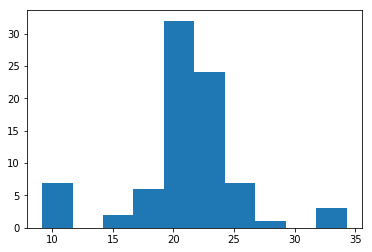

In [27]:
plt.hist(velocities)

In [28]:
velocities_min, velocities_max = velocities.min(), velocities.max()
X = np.linspace(velocities_min, velocities_max, 1000).reshape(-1, 1)

In [29]:
from scipy.optimize import minimize_scalar
from sklearn.neighbors.kde import KernelDensity
from functools import partial
def foo(h, velocities):
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(velocities)
    Y = kde.score_samples(X)
    return np.sum(np.diff(np.sign(np.diff(Y))) == -2) + h

In [31]:
from functools import partial
h = minimize_scalar(partial(foo, velocities=velocities.reshape(-1, 1)), 
                method='bounded', bounds=(0., 5.)).x

In [32]:
print(h)

3.045903459734463


In [33]:
B = 1000
velocities = velocities.ravel()

$$X_i^* = \bar{X} + \frac{X_j - \bar{X} + h N(0, 1)}{\sqrt{1 + h^2 / \hat{\sigma}^2}}$$

$X_j$ -- случайные сэмплы из данных, $X_i^x$ -- бутстрапный сэмпл.

In [34]:
X_b = np.random.choice(velocities.ravel(), (B, len(velocities)))
epsilons = np.random.randn(B, len(velocities))
velocities_mean = velocities.mean()
velocities_std_2 = velocities.std() ** 2
X_b = velocities_mean + (1 + h**2 / velocities_std_2)**(-0.5) * (X_b - velocities_mean + h * epsilons)

In [35]:
from tqdm import tqdm
h_boots = []
for bootstrap in tqdm(X_b):
    h_b = minimize_scalar(partial(foo, velocities=bootstrap.reshape(-1, 1)), 
                          method='bounded', bounds=(0., 5.)).x
    h_boots.append(h_b)

100%|██████████| 1000/1000 [03:07<00:00,  5.34it/s]


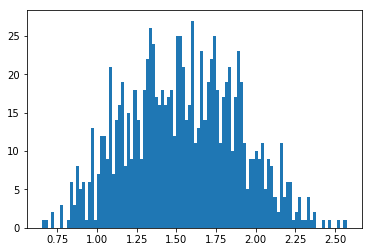

In [36]:
plt.hist(h_boots, bins=100);

In [37]:
p_value = np.mean(np.array(h_boots) > h)

In [38]:
p_value

0.0

Вывод: $H_0$ отвергается, распределение не унимодально.


Вы скажете: как это просто. А ведь 20 лет назад используя такой подход статью в Q1 написали!

http://www2.imm.dtu.dk/courses/02443/projects/Roeder_JASA_1990.pdf

# Параметрический бутстрап временных рядов


Бутстреп временных рядов обычно делают в два шага:

  1. Обучают модель для предсказания временного ряда(авторегрессия, к примеру).
  $$y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2}$$
  2. Запоминают остатки(residuals) от истинных значений и предсказанных:
  $$\hat{\epsilon} = y_t - (\beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2})$$
  3. Новые данные сэмплируют применяя обученную модель и добавляя к предсказанию случайно выбранное значение из residuals:
  $$\hat{y_t} = \beta_0 + \beta_1 \hat{y}_{t-1} + \beta_2 \hat{y}_{t-2} + (\epsilon \sim \hat{\epsilon}) $$
  
  
https://onlinecourses.science.psu.edu/stat501/node/358/

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pandas as pd
clf = linear_model.LinearRegression(fit_intercept=False)

In [59]:
def make_regression_from_timeseries(X, n):
    """
    X: 1D-numpy массив временных данных
    n: количество сэмплов для предсказания
    return: X, Y = [x_{t-n}, x_{t-n+1}, ..., x_{t-1}], x_{t}
    """
    N = len(X)
    x = np.zeros((N-n, n))
    y = np.zeros((N-n, 1))

    for i in range(N-n):
        x[i,:] = X[i: i+n]
        y[i] = X[i+n]

    return x,y
def bootstrap_timeseries(clf, xinit, residuals, N):
    n = len(xinit)
    bootstrap_sample = []
    current_sample = xinit
    for i in range(N):
        new_dot = clf.predict([current_sample]).ravel()[0] + np.random.choice(residuals)
        bootstrap_sample.append(new_dot)
        current_sample = np.roll(current_sample, -1)
        current_sample[-1] = new_dot
    return bootstrap_sample

n = 3 # авторегрессионный процесс первого порядка AR(1)

In [60]:
data = pd.read_csv('./goog.csv')['Close'].values[::-1][:600]

data_mean = data.mean()
data = data - data_mean
# создаём обучающую выборку
X, Y = make_regression_from_timeseries(data.ravel(), n)

clf.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [61]:
beta_hat = clf.coef_

In [62]:
# остатки = реальные данные - предсказания модели
residuals = Y.ravel() - clf.predict(X).ravel()

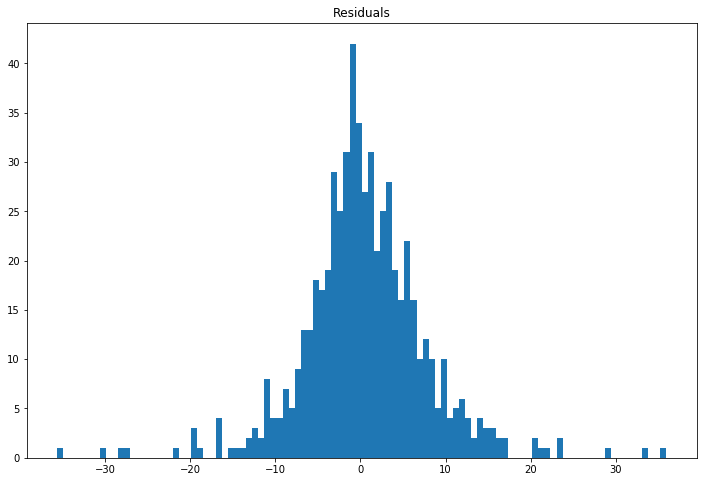

In [63]:
# мы хотим чтобы остатки были распределены по нормальному закону около нуля
# это является индикатором что ошибки случайны и не коррелируют
plt.figure(figsize=(12, 8))
plt.title('Residuals')
plt.hist(residuals, bins=100);
plt.show()

In [64]:
# бутстрепом набираем выборку коэффициентов линейной регрессии
beta_boots = []
B = 100
for i in tqdm(range(B)):
    bootstraped_data = bootstrap_timeseries(clf, X[0, :], residuals, len(data))
    X_boot, Y_boot = make_regression_from_timeseries(bootstraped_data, n)
    beta_boots.append(clf.fit(X_boot, Y_boot).coef_)
beta_boots = np.concatenate(beta_boots)

100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


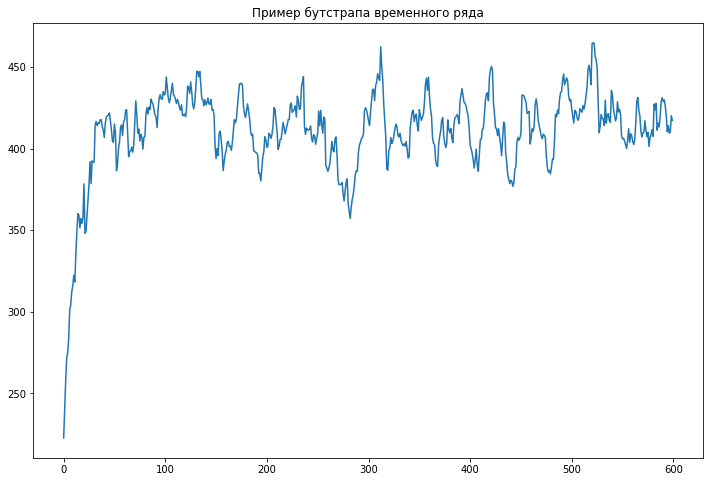

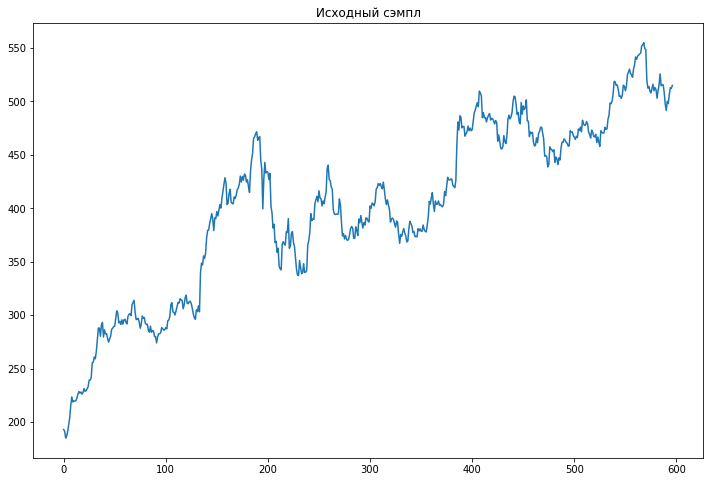

In [65]:
plt.figure(figsize=(12, 8))
plt.title('Пример бутстрапа временного ряда')
plt.plot(bootstraped_data + data_mean)
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Исходный сэмпл')
plt.plot(Y + data_mean)
plt.show()

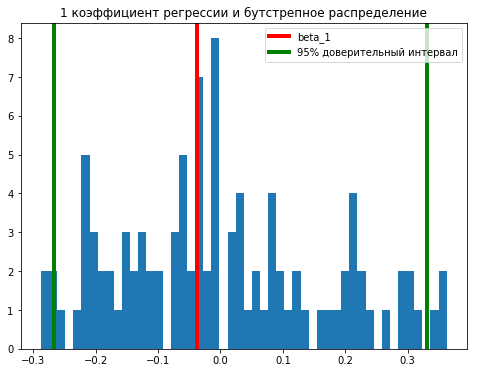

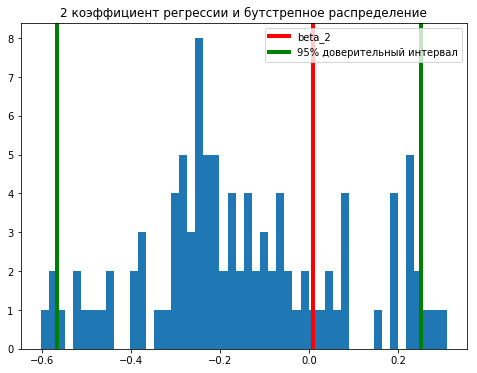

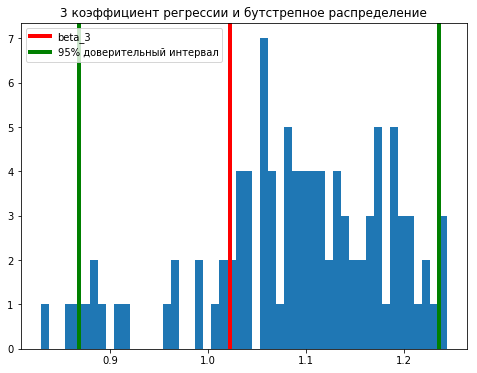

In [66]:
K = beta_boots.shape[1]
for k in range(K):
    plt.figure(figsize=(8, 6))
    plt.title("{} коэффициент регрессии и бутстрепное распределение".format(k + 1))
    lower_interval, higher_interval = percentile_confidence_interval(beta_boots[:, k], q=5)
    plt.hist(beta_boots[:, k], bins=50);
    plt.axvline(x=beta_hat[0][k], linewidth=4, color='r', label='beta_{}'.format(k+1))
    plt.axvline(x=lower_interval, linewidth=4, color='g', label='95% доверительный интервал'.format(k+1))
    plt.axvline(x=higher_interval, linewidth=4, color='g')
    plt.legend()
    plt.show()

Как вы видите, для авторегрессии 1 порядка верно следующее:
  * Измеренное значение лежит в 95% доверительном интервале
  * Доверительный интервал достаточно далеко от 0
  
Второй факт означает следующее: если бы мы тестировали гипотезу о том равна ли $\beta_1$ нулю, то с 95% вероятностью эта гипотеза отвергалась бы.

Проверьте, верно ли это для AR(2)?

# Сравнение  интервалов t-bootstrap и обычного  бутстреп

### Оценка доверительного интервала

Предположим, что у нас есть некоторая $\theta = T(X)$, то с помощью бутстрапа мы можем сгенерировать новую, бутстрапную, выборку:

$$\{ \hat{\theta}_i \}_{i=0}^{B}$$

По этой выборке можно оценивать не только стандартную ошибку, но и доверительные интервалы. Мы сравним два подхода для подсчёта доверительных интервалов. 


##### $1 - 2 \alpha$ центральный интервал:

$$C_n = 2 T_n(X) - (T_b^*)^{(1 - \alpha)}, 2 T_n(X) - (T_b^*)^{(\alpha)}$$

##### $1 - 2 \alpha$ нормальный интервал:

$$C_n = T_n(X) - z_{\alpha}v_{boot}, T_n(X) - z_{1 - \alpha}v_{boot}$$

##### $1 - 2 \alpha$ перцентильный интервал:

$$C_n = \left(\hat{\theta}^{(\alpha)}, \hat{\theta}^{(1 - \alpha)}\right)$$

##### $1 - 2 \alpha$ bootstrap-t интервал:


Bootstrap-t оценивается по-другому:

$$C_n = \left( \hat{\theta} - \hat{se} \cdot \hat{t}^{(1 - \alpha)}, \hat{\theta} - \hat{se} \cdot \hat{t}^{(\alpha)} \right),$$

где квантили $t$ считаются от следующих оценок по бутстрапным выборкам:

$$t^*(b) = \frac{\hat{\theta}^*(b) - \hat{\theta}}{\hat{se}^*(b)}$$

In [67]:
from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import expon
def mean(X):
    return np.mean(X, axis=1)

def mean_t(X, X_original):
    return (np.mean(X, axis=1) - np.mean(X_original)) / np.std(X, axis=1)

def percentile_confidence_interval(X, q=5):
    return np.percentile(X, q=q / 2), np.percentile(X, q=100 - q / 2)

In [68]:
def plot_statistics(distr, limits_1, limits_2, limits_3, mean_val):
    X = distr.rvs(size=N)
    boots = np.random.choice(X, (B, N), replace=True)
    mean_boots = mean(boots)
    mean_boots_t = mean_t(boots, X)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig.suptitle('{} distribution. N={}, B={}'.format(distr.dist.name, N, B))
    axes[0].hist(X, bins=100, density=True, range=limits_1);
    axes[0].axvline(x=mean_val, linewidth=4, color='r')
    axes[0].set_xlim(limits_1)
    # axes[0].legend()
    axes[1].hist(mean_boots, bins=100, density=True, range=limits_2);
    # axes[1].axvline(x=mean_val, linewidth=4, color='r')
    lower_interval, higher_interval = percentile_confidence_interval(mean_boots)
    axes[1].axvline(x=lower_interval, linewidth=1, 
                    color='r', linestyle='--')
    axes[1].axvline(x=higher_interval, linewidth=1, 
                    color='r', linestyle='--', label='Percentile bootstrap interval')
    lower_interval, higher_interval = percentile_confidence_interval(mean_boots_t)

    axes[1].axvline(x=X.mean() - X.std() * higher_interval, linewidth=1, 
                    color='g', linestyle='-')
    axes[1].axvline(x=X.mean() - X.std() * lower_interval, linewidth=1, 
                    color='g', linestyle='-', label='t-bootstrap interval')
    axes[1].set_xlim(limits_2)
    axes[1].legend()
    
    axes[2].hist(mean_boots_t, bins=100, density=True, range=limits_3);
    # axes[2].axvline(x=0, linewidth=4, color='r')
    lower_interval, higher_interval = percentile_confidence_interval(mean_boots_t)
    axes[2].axvline(x=lower_interval, linewidth=1,
                    color='r', linestyle='--')
    axes[2].axvline(x=higher_interval, linewidth=1, 
                    color='r', linestyle='--', label='t-bootstrap interval')
    axes[2].set_xlim(limits_3)
    axes[2].legend()
    plt.show()

In [69]:
N = 50
B = 5000

### Распределение Коши

![распределение Коши](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Cauchy_pdf.svg/360px-Cauchy_pdf.svg.png)

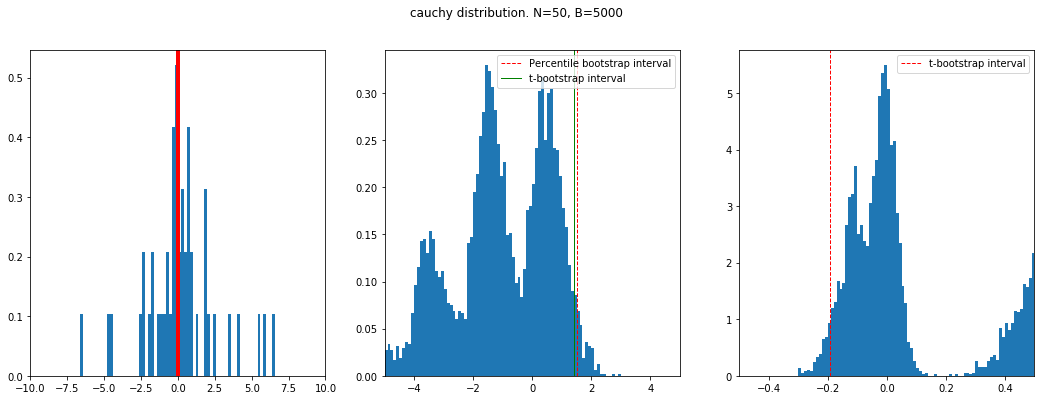

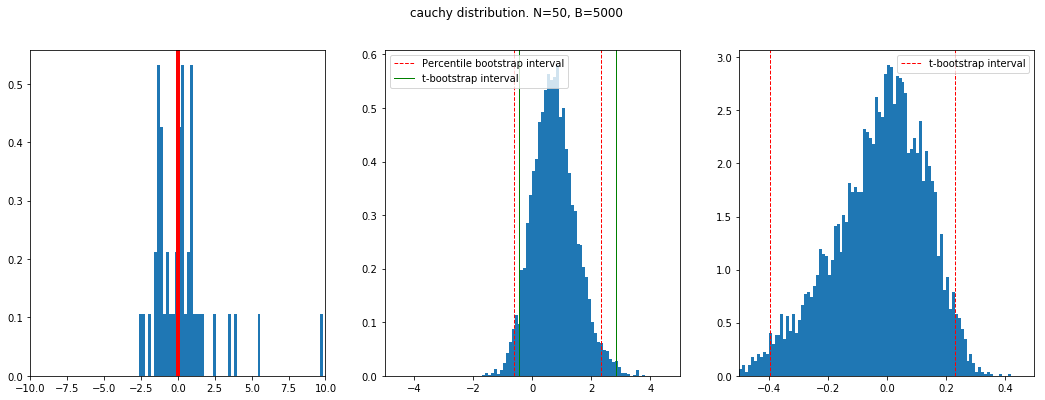

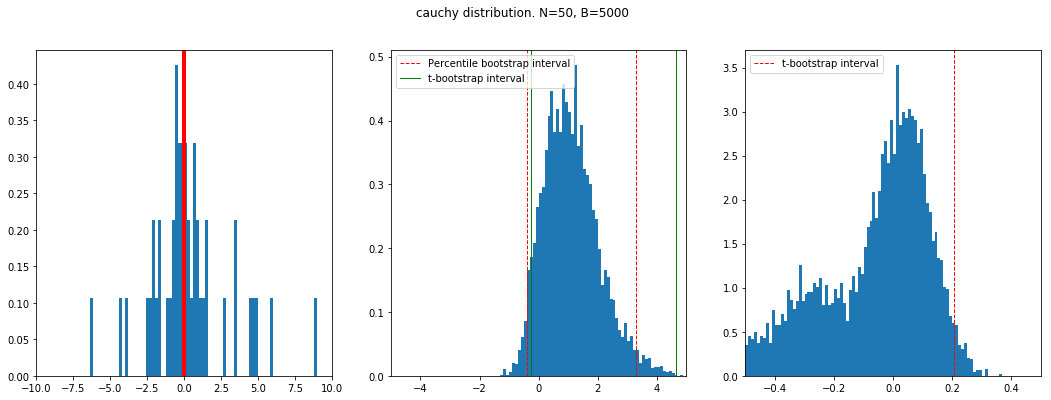

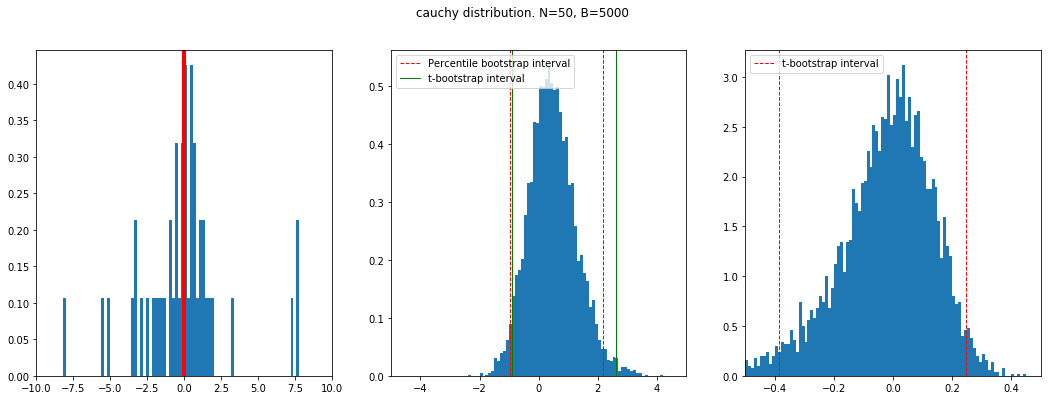

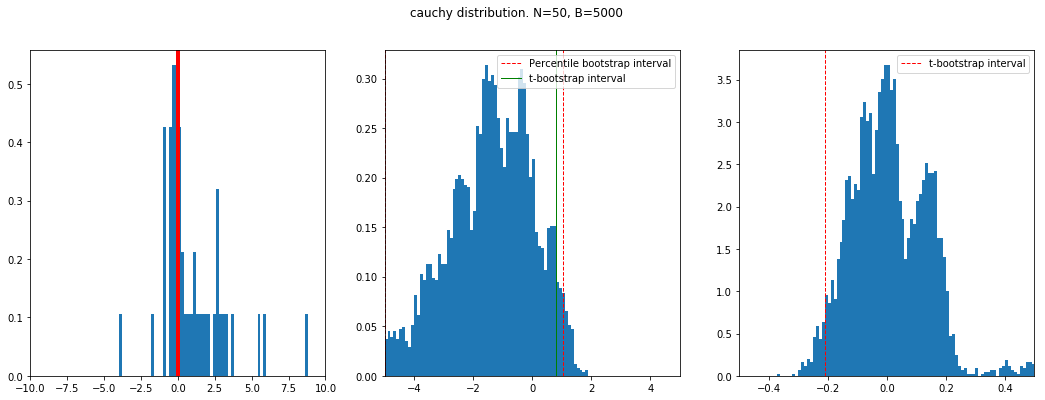

In [70]:
for i in range(5):
    plot_statistics(cauchy(), [-10, 10], [-5, 5], [-0.5, 0.5], 0)

# Нормальное распределение

![Нормальное распределение](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/1080px-Normal_Distribution_PDF.svg.png)

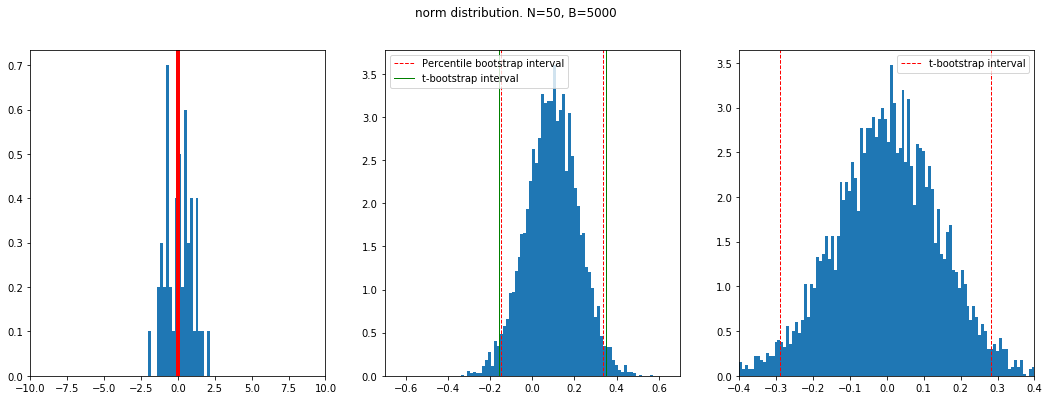

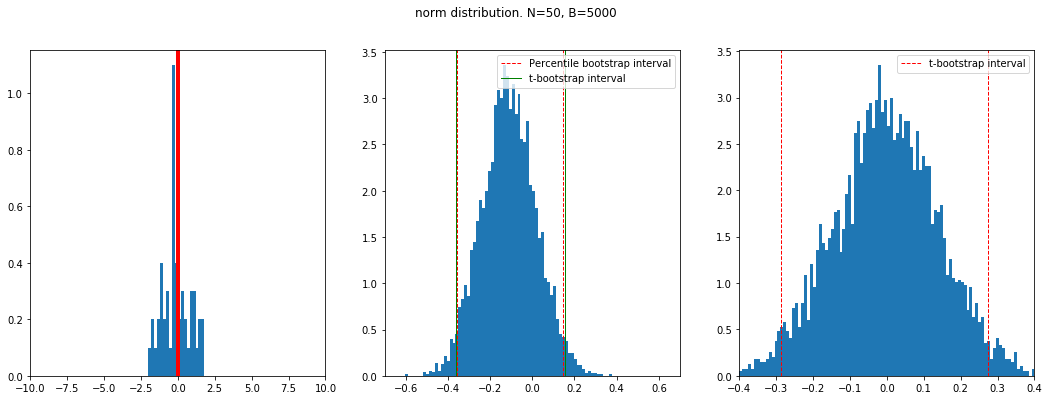

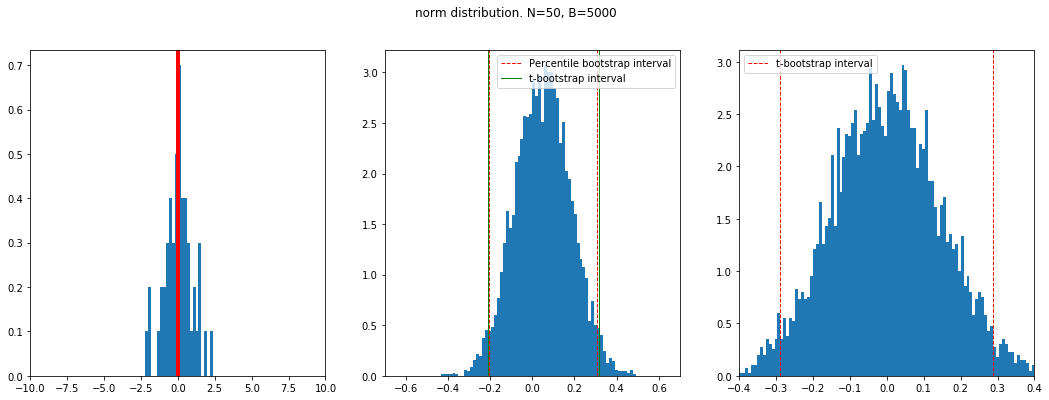

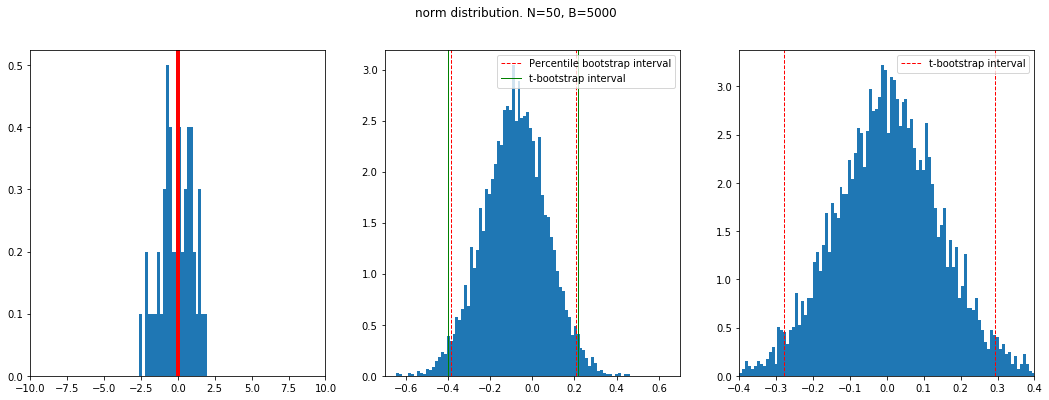

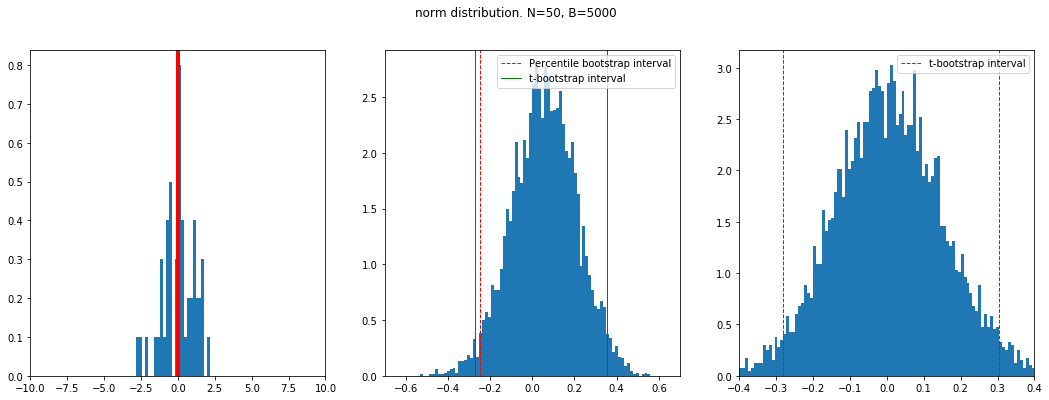

In [71]:
for i in range(5):
    plot_statistics(norm(), [-10, 10], [-0.7, 0.7], [-0.4, 0.4], 0)

# Экспоненциальное распределение
![экспоненциальное распределение](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/360px-Exponential_pdf.svg.png)

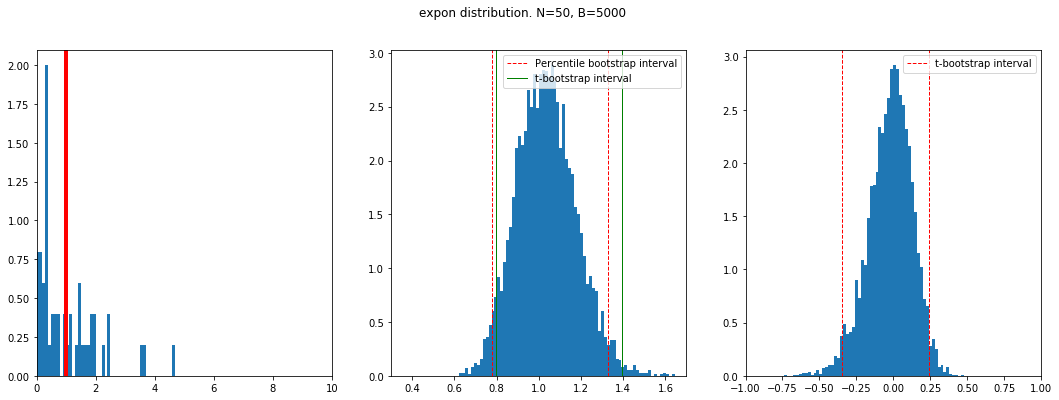

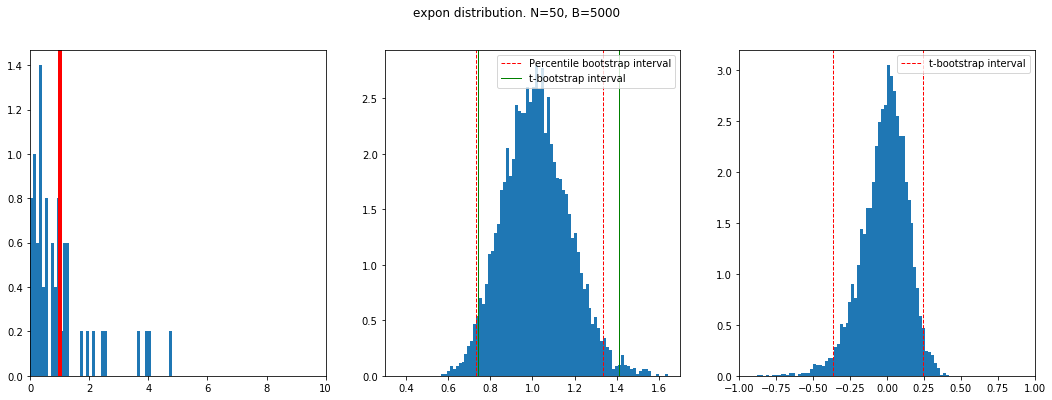

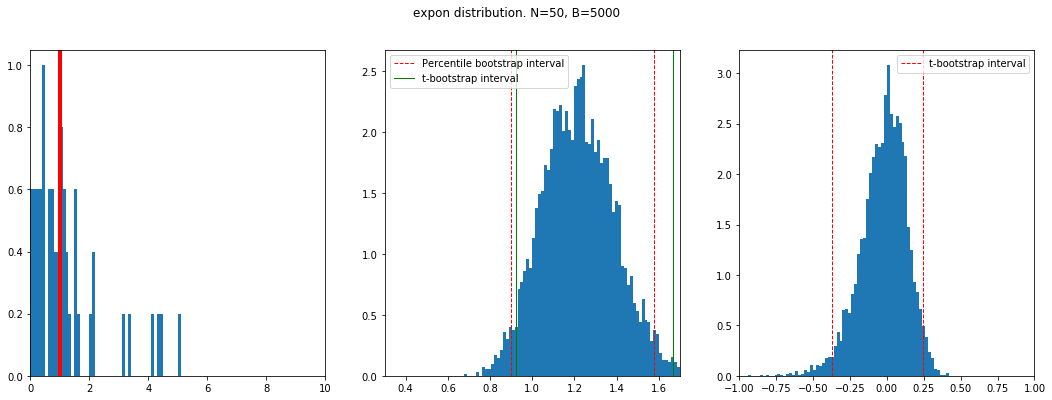

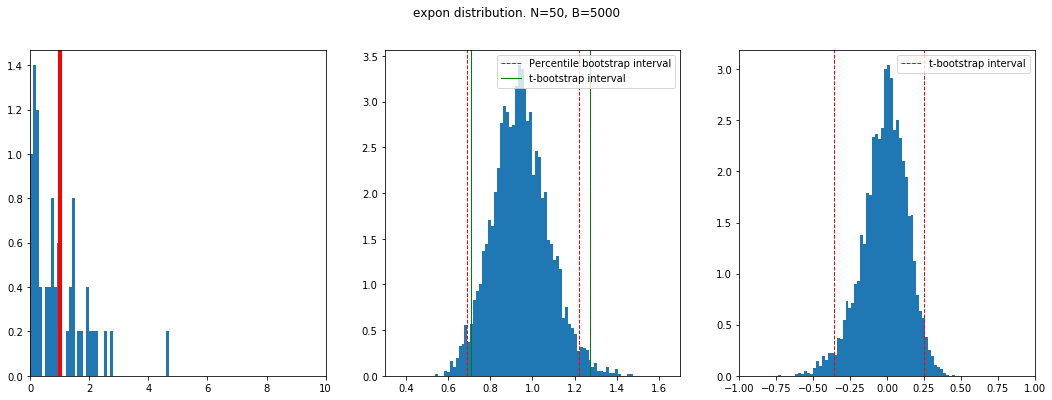

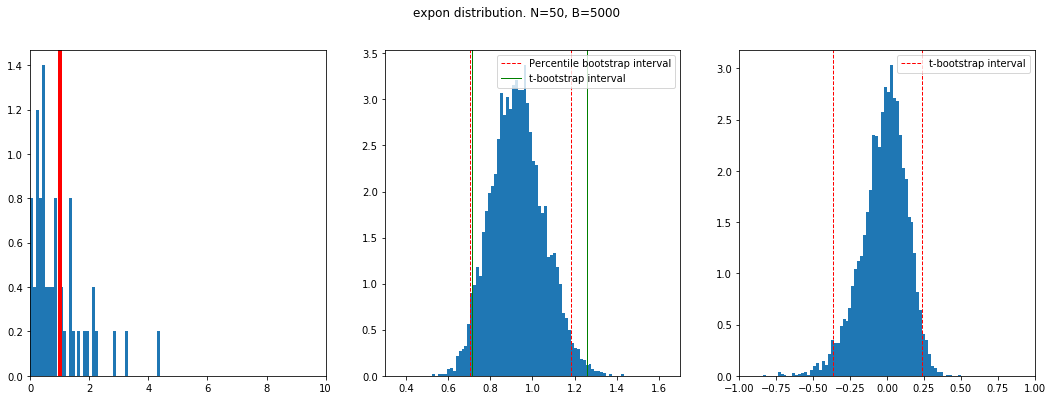

In [72]:
# 5 различных random seed для экспоненциального распределения
for i in range(5):
    plot_statistics(expon(), [0, 10], [1. - 0.7, 1. + 0.7], [-1, 1], 1)

## Вывод

В целом, перцентильный интервал выглядит самым простым вариантом оценивания, однако в реальности он даёт весьма плохие результаты так как __сильно__ зависит от того насколько хорошо изначальная выборка аппроксимирует истинное распределение случайной величины. Часто можно встретить советы что лучше __не используйте__ перцентильный бутстрап для оценки доверительных интервалов, однако, конечно, самое правильное решение это тестировать все доступные методы.

У t-bootstrap есть одно интересное свойство, к примеру,: как можно было заметить на последнем примере с экспоненциальным распределением, интервалы t-bootstrap смещены влево. t-bootstrap "уважает" ассиметрию распределений при расчёте доверительных интервалов.

## Bootstrap and jacknife bias estimatiom

Посмотрим как можно оценивать смещение оценки с помощью бутстрепа и jacknife на трёх примерах:


  * $x_i \sim Exp(1)$, $\theta = \sigma^2$, $\hat{\theta} = \frac{1}{N} \sum (x_i - \bar{x})^2$ -- смещённая оценка дисперсии. $\hat{\theta} = \frac{1}{N - 1} \sum (x_i - \bar{x})^2$ -- несмещённая оценка.
  * $x_i \sim U(0, \theta)$, $\hat{\theta} = \max(x_i)$ -- смещённая оценка максимума равномерного распределения. $\hat{\theta} = \frac{N + 1}{N}\max(x_i)$ -- несмещённая оценка.
  * $x_i \sim U\{0, \theta\}, \theta \in N$, $\hat{\theta} = \max(x_i)$ -- смещённая оценка максимума равномерного дискретного распределения. $\hat{\theta} = \frac{N + 1}{N} \max(x_i) - 1$  -- несмещённая оценка.
  
  Зачем нужно уметь оценивать максимум дискретного распределения? Чтобы увидев на танке противника №60 дать состоятельную и несмещённую оценку общего числа танков ;)
  
  ![](https://upload.wikimedia.org/wikipedia/commons/6/61/Bundesarchiv_Bild_183-H26258%2C_Panzer_V_%22Panther%22.jpg)
  
  https://en.wikipedia.org/wiki/German_tank_problem

## Jacknife

Jacknife бутстрап строится на leave-one-out статистиках, т.е. статистиках посчитанных на всех измерениях кроме одного:

$$\hat{\theta}_{(-i)} = \theta(X_{(-i)})$$

$$\hat{\theta}_{(\cdot)} = \frac{1}{N} \sum\limits_{i=1}^{N} \hat{\theta}_{(-i)}$$

Для jacknife оценка дисперсии выглядит следующим образом:

$$v_{jack} = \frac{n-1}{n} \sum\limits_{i=1}^{n} \left(\hat{\theta}_{(\cdot)} - \hat{\theta}_{(-1)}\right)^2$$


#### Bias

Смещение(bias) это разница между мат. ожиданием оценки статистики по сэмплу конечного размера и реальной величиной. 

$$bias_F = bias_F(\hat{\theta}, \theta) = E_F[\hat{\theta}] - \theta(F)$$

Так как распределение $F$ нам неизвестно, то оценивать мы будем по бутстрапному распределению, т.е.:

$$bias_{\hat{F}} = bias_{\hat{F}}(\hat{\theta}, \theta) = E_{\hat{F}}[\hat{\theta}^*] - \theta(\hat{F})$$

#### Bootstrap bias & jacknife bias

Для оценки смещения сравним обычный бутстреп и jacknife.

Для бутстрепа смещение считается следующим образом(следует из формулы :

$$\hat{bias}_B = \hat{\theta}^* - \hat{\theta}$$

Для jacknife смещение __определяется__ следующим образом:

$$\hat{bias}_{jack} = (n - 1) ( \hat{\theta}_{(\cdot)} - \hat{\theta})$$


#### Коррекция

В общем случае коррекция делается следующим образом:

$$\bar{\theta} = \hat{\theta} - \hat{bias}$$

Однако следует осознанно делать коррекцию, так как оценка смещения может иметь большую ошибку и тогда уменьшение смещения оценки будет __нивелировано__ возросшей дисперсией.

https://arxiv.org/pdf/1709.06183.pdf

#### Доказательство квадратичной точности jacknife bias estimation

Для доказательства квадратичной точности оценки смещения jacknife сделаем одно простое предположение, что матожидание нашей статистики при ограниченном размере выборки раскладывается в ряд Тейлора от размера выборки:

$$E_F \hat{\theta} = \theta + \frac{a_1(F)}{n-1} + \frac{a_2(F)}{(n - 1)^2} + \dots$$

Подставим в формулу коррекции смещения jacknife оценку смещения:

$$\hat{\theta} - \hat{bias}_{jack} = \hat{\theta} - (n - 1) ( \hat{\theta}_{(\cdot)} - \hat{\theta}) = n \hat{\theta} - (n - 1) \hat{\theta}_{(\cdot)}$$

Теперь возьмём от этого матожидание и разложим его по Тейлору:

$$E_F \left[ n \hat{\theta} - (n - 1) \hat{\theta}_{(\cdot)} \right] =  n\left(\theta + \frac{a_1(F)}{n} + \frac{a_2(F)}{n^2} + \dots\right) + $$

$$ (n-1) \left( \theta + \frac{a_1(F)}{n-1} + \frac{a_2(F)}{(n-1)^2} + \dots \right) = $$

$$ = \theta - \frac{a_2(F)}{n(n-1)} + o\left(\frac{1}{n^2}\right)$$

Как видно, jacknife избавляется от линейного члена в разложении смещения по размеру выборке.

In [73]:
def jackknife_resampling(data):
    n = data.shape[0]
    resamples = np.empty([n, n-1])
    for i in range(n):
        resamples[i] = np.delete(data, i)
    return resamples


def jackknife_stats(data, statistic):
    from scipy.special import erfinv
    n = data.shape[0]
    resamples = jackknife_resampling(data)

    stat_data = statistic(data)
    jack_stat = np.apply_along_axis(statistic, 1, resamples)
    mean_jack_stat = np.mean(jack_stat, axis=0)

    bias = (n - 1) * (mean_jack_stat - stat_data)

    estimate = stat_data - bias

    return stat_data, bias, estimate

def bootstrap_stats(X, statistic, B=1000):
    boots = np.random.choice(X, (B, N), replace=True)
    stat_data = np.mean(statistic(boots, axis=1))
    bias = stat_data - statistic(X)
    
    estimate = statistic(X) - bias

    return stat_data, bias, estimate

### Оценка $\sigma^2$ для экспоненциального распределения

In [74]:
def plot_bias_comparison_sigma(N=10):
    X = expon().rvs(N)
    
    true_bias = np.std(X) - np.std(X, ddof=1)
    _, jack_bias, _ = jackknife_stats(X, statistic=np.std)

    Bs = np.logspace(1, 3, 20).astype(int)
    boot_biases = []
    for B in Bs:
        _, boot_bias, _ = bootstrap_stats(X, statistic=np.std, B=B)
        boot_biases.append(boot_bias)
        
    plt.figure(figsize=(12, 7))
    plt.plot(Bs, boot_biases, label='Bootstrap bias')
    plt.axhline(true_bias, c='g', label='True bias')
    plt.axhline(jack_bias, c='r', label='Jacknife bias')
    
    plt.legend()
    plt.show()

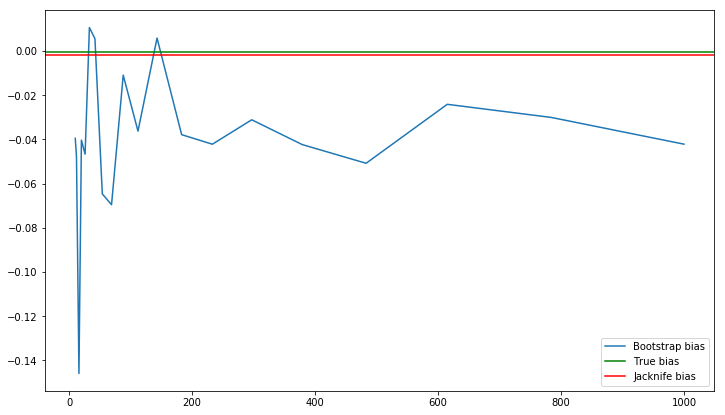

In [75]:
plot_bias_comparison_sigma(N=1000)

In [76]:
from scipy.stats import kurtosis
def plot_bias_comparison_kurtosis(N=10):
    X = expon().rvs(N)
    
    true_bias = kurtosis(X) - kurtosis(X, bias=False)
    _, jack_bias, _ = jackknife_stats(X, statistic=kurtosis)

    Bs = np.logspace(1, 3, 20).astype(int)
    boot_biases = []
    for B in Bs:
        _, boot_bias, _ = bootstrap_stats(X, statistic=kurtosis, B=B)
        boot_biases.append(boot_bias)
        
    plt.figure(figsize=(12, 7))
    plt.plot(Bs, boot_biases, label='Bootstrap bias')
    plt.axhline(true_bias, c='g', label='True bias')
    plt.axhline(jack_bias, c='r', label='Jacknife bias')
    
    plt.legend()
    plt.show()

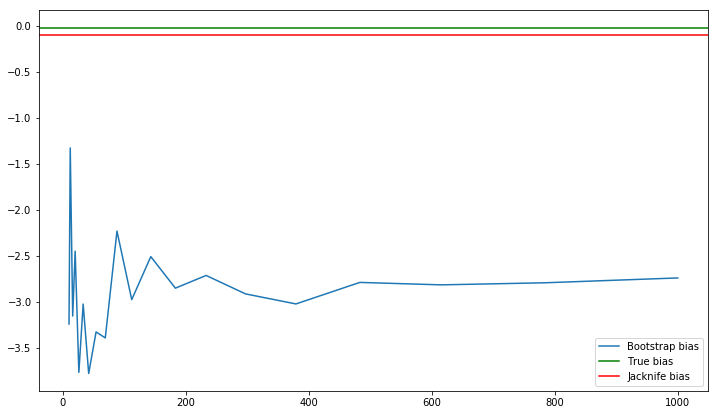

In [77]:
plot_bias_comparison_kurtosis(N=2000)

### Оценка $\theta$ для $U[0, \theta]$ и для $U\{0, \theta\}$

In [78]:
def plot_bias_comparison_sigma_uniform(N=10):
    X = np.random.uniform(0, 1, N)
    
    true_bias = np.max(X) - np.max(X) * (len(X) + 1) / len(X)

    _, jack_bias, _ = jackknife_stats(X, statistic=np.max)
    boot_biases = []

    Bs = np.logspace(1, 4, 20).astype(int)

    for B in Bs:
        _, boot_bias, _ = bootstrap_stats(X, statistic=np.max, B=B)
        boot_biases.append(boot_bias)
        
    plt.figure(figsize=(12, 7))
    plt.plot(Bs, boot_biases, label='Bootstrap bias')
    plt.axhline(true_bias, c='g', label='True bias')
    plt.axhline(jack_bias, c='r', label='Jacknife bias')
    
    plt.legend()
    plt.show()

def plot_bias_comparison_sigma_discrete(N=10, theta=100):
    X = np.random.choice(np.arange(0, int(theta)), size=N, replace=True)
    # X = np.random.choice(np.arange(0, int(theta)), size=N, replace=False)
    true_bias = np.max(X) - (np.max(X) * (len(X) + 1) / len(X))

    _, jack_bias, _ = jackknife_stats(X, statistic=np.max)
    boot_biases = []

    Bs = np.logspace(1, 4, 20).astype(int)

    for B in Bs:
        _, boot_bias, _ = bootstrap_stats(X, statistic=np.max, B=B)
        boot_biases.append(boot_bias)

    plt.figure(figsize=(12, 7))
    plt.plot(Bs, boot_biases, label='Bootstrap bias')
    plt.axhline(true_bias, c='g', label='True bias')
    plt.axhline(jack_bias, c='r', label='Jacknife bias')
    
    plt.legend()
    plt.show()

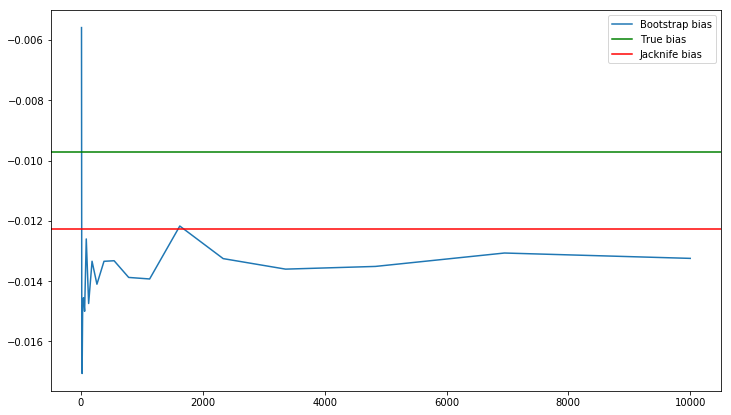

In [79]:
# запустите несколько раз
plot_bias_comparison_sigma_uniform(N=100)

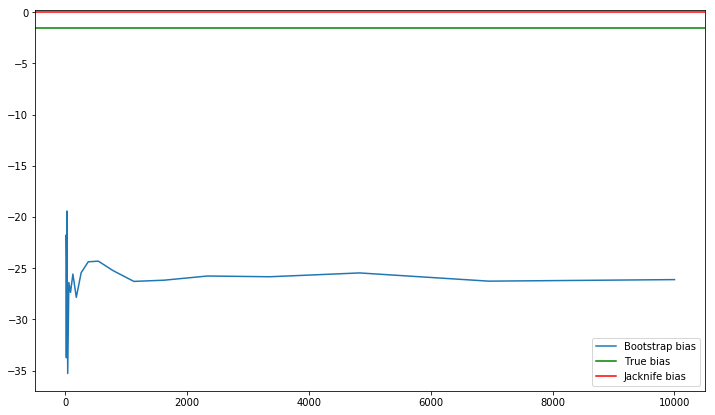

In [80]:
# запустите несколько раз
plot_bias_comparison_sigma_discrete(N=1000, theta=1500)

#### Общее наблюдение

Оценка смещения jacknife имеет более высокий порядок точности($o\left(\frac{1}{N^2}\right)$) чем бутстрепная оценка($o\left(\frac{1}{N}\right)$), что можно увидеть на примере оценки дисперсии и куртозис, поэтому имеет смысл в большинстве случаев использовать jacknife для оценки смещения.

Однако, jacknife "ломается" на негладких статистиках: медиана, максимум, к примеру. В этом случае лучше использовать обычный bootstrap.

? resampling